# Purpose of Notebook

## Model Descriptions
We suppose that $X(t,T): \mathbb{R}^2_+ \mapsto [0,1]$ is the _recrystillization fraction_, and is a function of $t$ the time and $T$ the _isothermal_ and _steady_ temperature, (_i.e._ the temperature is uniform in space and independent of time).

### JMAK

The parameters of interest are the incubation time $t_{inc}$, the exponent, $n$, and the rate coefficient $b$. $A_1,A_2,A_1,A_2$ are parameters involved in the Arrhenius process description of the temperature dependence of $b$ and $t_{inc}$ on $T$. 

$
X = 1 - \exp{\left( -b^n (t - t_{inc})^n \right)} + \epsilon \\ 
b = A_1 \exp{\left(B_1/T \right)} \\ 
t_{inc} = A_2 \exp{\left(B_2/T \right)} \\ 
$

### Generalized Logistic 

We suppose that the recrystillization fractionmay be modeled using a (generalized) logistic (GL) growth function. The temperature dependence follows through the Arrhenius process modeled for the growth rate $B$ and starting time $M$.

$
X = \frac{1}{(1 + e^{-B (t - M)})^{1/\nu}} \\ 
B = A_1 \exp{\left(B_1/T \right)} \\ 
M = A_2 \exp{\left(B_2/T \right)} \\ 
$

Note that because the parameters tend to be on very different scales, we employ a log re-parameterization. That is, for example, 

$\ln{B} = \ln{A_1} + \frac{B_1}{T} = a_1 + \frac{B_1}{T} \implies B = \exp{\left( a_1 + \frac{B_1}{T}\right)}$

where $a_1 = \ln{A_1}$

## Model Assessment
###  Model Fit
    1. Non-Linear Least Squares
    2. Weighted Non-Linear Least Squares
    3. Robust Regression

### Assessing application: Extrapolation to lower temperatures

### TO-DO
1. 3rd order Arrhenius with "fudge factor" - just fit a linear model and use these parameters to initialie a search for $\beta$ exponent in "stretched" model. Hopefully can improve the fit.
2. Assess model fit using likelihood, on extrapolation and  incorporating errors of data
    - DFFITS, Cooks D implementation
    - look up if the weighted least squares in scipy's implementation does white + W or sigma*W
    - use this error to scale residuals for analysis
3. Extend to Richou's data

In [4]:
import numpy as np
from scipy.optimize import differential_evolution, curve_fit, OptimizeResult
from typing import Callable, Tuple
from dataclasses import dataclass
import math
import warnings
from matplotlib import pyplot as plt
from functools import partial
from matplotlib import rc
from abc import ABC, abstractmethod
from common_util import LogLinearArrhenius,FudgeFactorArrhenius,ArrheniusProcess

rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
warnings.filterwarnings('ignore',category = RuntimeWarning)
warnings.filterwarnings('ignore',category = SyntaxWarning)

def jmak_function(t: np.ndarray,b: float,t_inc: float,n: float):
    1.0 - np.exp(-b**n*(t - t_inc)**n)
    yhat = np.empty_like(t)
    index = t >= t_inc
    yhat[~index] = 0.
    yhat[index] = 1.0 - np.exp(-b[index]**n*(t[index]-t_inc[index])**n)
    return yhat

def generalized_logistic(t: np.ndarray,B: float,M: float,nu: float):
    return 1/(1 + np.exp(-B*(t - M)))**(1/nu)
        
@dataclass
class ModelFunc:
    
    rxFunc: Callable = None
    n: float = None
    p1: np.ndarray = None
    p2: np.ndarray = None
    ap1: ArrheniusProcess = LogLinearArrhenius()
    ap2: ArrheniusProcess = LogLinearArrhenius()

    def _func(self,x:np.ndarray,*params):
        self.ap1.params = params[1:self.ap1.p + 1]
        self.ap2.params = params[1+ self.ap1.p:]
        return self.rxFunc(x[:,0],self.ap1(x[:,1]),self.ap2(x[:,1]),params[0])
    
    def __call__(self,x : np.ndarray):
        return self._func(x,*self.parameters())
    
    def parameters(self):
        return np.concatenate([[self.n],self.p1,self.p2])
    
    def set_parameters(self,params: np.ndarray):
        self.n = params[0]
        self.p1 = params[1:1+self.ap1.p]
        self.p2 = params[1+self.ap1.p:]

    def fit(self,rxFunc: Callable,
                t: np.ndarray,
                 T: np.ndarray,
                 Y: np.ndarray,
                 opt_method: Callable,
                 bounds: Tuple[np.ndarray],
                 ap1_order = 2,
                 ap2_order = 2,
                 **kwargs):
        
        self.ap1 = FudgeFactorArrhenius() if ap1_order == 3 else LogLinearArrhenius()
        self.ap2 = FudgeFactorArrhenius() if ap2_order == 3 else LogLinearArrhenius()
        
        self.rxFunc = rxFunc
        opt_res = opt_method(self._func,np.array([t,T]).T, Y.copy(),bounds,**kwargs)
        
        if isinstance(opt_res,OptimizeResult):
            x,flag,msg = opt_res.x.copy(),opt_res.success,opt_res.message
        else:
            x,flag,msg = opt_res
        
        if flag:
            self.set_parameters(x)
            return self
        else:
            raise ValueError(f'Optimization failed: {msg}')

        
def global_optimize_ls(f: Callable,
                       xdata: np.ndarray,
                       ydata: np.ndarray,
                       bounds: np.ndarray,
                       sigma: np.ndarray = None,
                       p0: np.ndarray = None,
                       *args,**kwargs):
    
    w = np.ones_like(ydata) if not isinstance(sigma,np.ndarray) and sigma is None else 1/sigma**2
    w/=np.linalg.norm(w)

    def resid(theta: np.ndarray):
        return np.sum((w*(ydata - f(xdata,*theta))**2))
    
    return differential_evolution(resid,bounds,*args,polish = True,**kwargs)

def local_optimize_ls(fun: Callable,
                      xdata: np.ndarray,
                      ydata: np.ndarray,
                      bounds: np.ndarray,
                      *args,
                      p0: np.ndarray = None,
                      **kwargs):
    
    p0 = np.mean(bounds,axis = 1)
    
    xopt,pcov, info_dict,msg, ier = \
          curve_fit(fun,xdata,ydata,*args,p0 = p0,bounds = bounds.T,**kwargs,full_output = True)
    
    return xopt,True,msg


In [2]:
import pandas as pd
import pickle
from common_util import setup_axis_default

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

def get_arrhenius_parameter_bounds_from_file(plabel: str,
                                             file: str,
                                             order: int = 2,
                                             alpha = 1e-3):
    
    label = file_to_label[file]
    with open(f'.model/{plabel}_{label}_first_{order}.pkl','rb') as f:
        ols_res_f = pickle.load(f).conf_int(alpha)
    
    with open(f'.model/{plabel}_{label}_last_{order}.pkl','rb') as f:
        ols_res_l = pickle.load(f).conf_int(alpha)
    
    if order == 3:
        ols_res_l[-1] = np.array([0.1,3.0])
        ols_res_f[-1] = np.array([0.1,3.0])

    ci = np.concatenate([ols_res_f,
                         ols_res_l],axis = 1)
    
    bounds = np.array([np.min(ci,axis = 1),np.max(ci,axis = 1)]).T
    return bounds
    
def read_prepare_data(file: str,
                      mult = 1.,
                      exclude_index = []) -> pd.DataFrame:
    
    df = pd.read_csv(file,index_col = 0)
    index = np.ones(df.shape[0],dtype = bool)   
    index[exclude_index] = False
    df = df.loc[index,:]
    
    df['time']*=mult
    t = df['time'].to_numpy()
    T = df['temperature'].to_numpy() + 273.15
    X = df['X'].to_numpy()
    X[X <= 0 ] = 0.0
    X[X >= 1] = 1
    with warnings.catch_warnings(action = 'ignore'):
        df.loc[df['std'] == 0,'std'] = max(np.min(df.loc[df['std'] > 0,'std']),0.1e-3)
    

    return t,T,X,df

def jmak_fit_model_setup(file: str,
                         bounds_n: np.ndarray = np.array([[1.0,3.0]]),
                         mult = 1.,
                         tinc_order = 2,
                         b_order =2 ,
                         exclude_index = [],
                         **kwargs):
    
    bounds_tinc = get_arrhenius_parameter_bounds_from_file('log_tinc',file,order = tinc_order,**kwargs)
    bounds_b = get_arrhenius_parameter_bounds_from_file('log_b',file, order = b_order,**kwargs)
    bounds = np.concatenate([bounds_n,bounds_b,bounds_tinc],axis = 0)
    return *read_prepare_data(file, mult = mult,exclude_index = exclude_index),bounds

def gl_fit_model_setup(file: str,
                       bounds_nu: np.ndarray = np.array([[1e-3,1.0]]),
                       mult = 1.,
                       M_order = 2,
                        B_order = 2,
                        exclude_index = [],
                       **kwargs):
    
    bounds_B = get_arrhenius_parameter_bounds_from_file('log_B',file, order = B_order,**kwargs)
    bounds_M = get_arrhenius_parameter_bounds_from_file('log_tinc',file,order = M_order, **kwargs)
    bounds = np.concatenate([bounds_nu,bounds_B,bounds_M],axis = 0)
    return *read_prepare_data(file,mult = mult,exclude_index = exclude_index),bounds




### Examining Regression Fits

IndexError: tuple index out of range

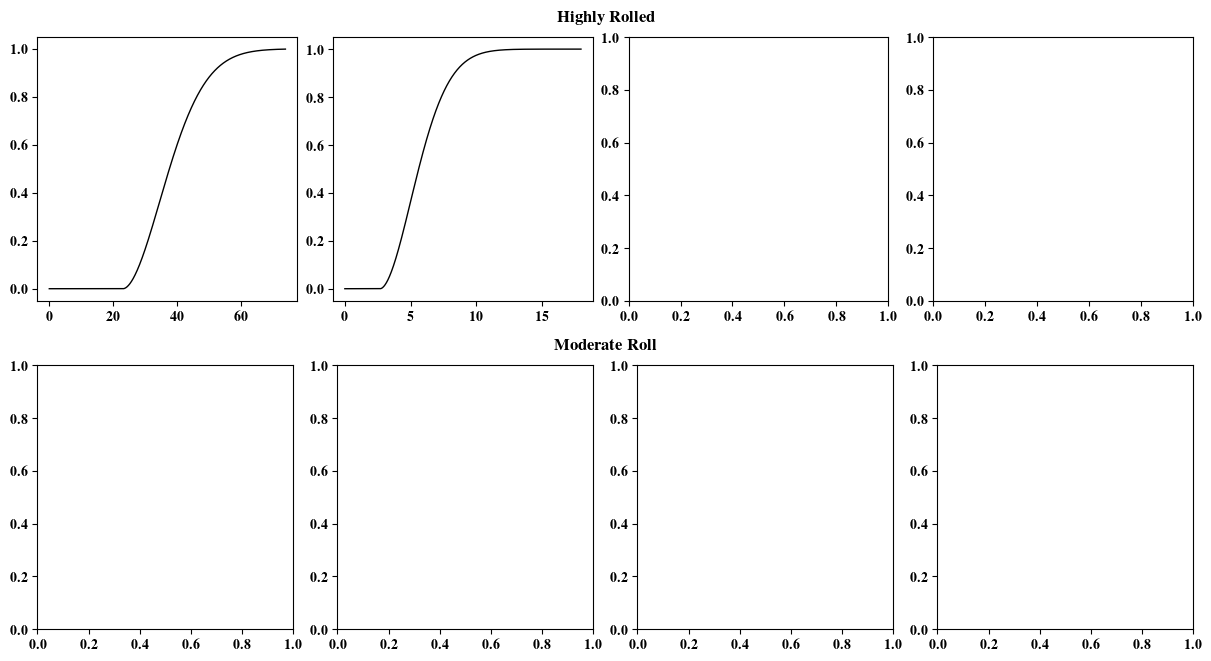

In [5]:
import copy

model_fit = {'JMAK':(jmak_fit_model_setup,jmak_function),
        'Generalized Logistic':(gl_fit_model_setup,generalized_logistic)}

methods = {'weighted_2':(2,'linear'),
           'weighted_3':(3,'linear'), 
           'weighted_robust_2':(2,'huber'),
           'weighted_robust_3':(3,'huber')}

models = {}
styles = ['-',':','--','-.']
labels = ['WLS - 2','WLS - 3','Robust WLS - 2','Robust WLS -3']
fig = plt.figure(constrained_layout=True,figsize= (12,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)

axes = []
for row, subfig,row_title in zip(range(2),subfigs,['Highly Rolled','Moderate Roll']):
        subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)
        axs = subfig.subplots(nrows=1, ncols=4)
        axes.append(axs)

axes = np.array(axes)

colors = plt.get_cmap('Dark2')([0.2,0.3])

data_files = {'highly_rolled.csv': [22,36],
                'moderate_roll.csv':[33,44,45]}

for j,file,temperatures in zip(range(2),data_files,[[1150,1250],[1150,1250]]):
        results_frames = []
        models[file] = {}
        data_file = f'rf_data/alfonso_data/{file}'
        data = pd.read_csv(data_file,index_col = 0)
        
        start_index = 0

        for model_to_fit in model_fit:
                setup,fit_func = model_fit[model_to_fit]
                models[file][model_to_fit] = {} 
                
                for method,ls,label in zip(methods,styles,labels): 
                        results = [] 
                        model_order,loss = methods[method]
                        if model_to_fit == 'JMAK':
                                t,T,X,df,bounds = setup(data_file,mult = 3600.,
                                                        exclude_index = data_files[file],
                                                        **{'tinc_order':model_order,'b_order':model_order})
                        else:
                                t,T,X,df,bounds = setup(data_file,mult = 3600.,
                                                        exclude_index = data_files[file],
                                                        **{'M_order':model_order,'B_order':model_order})
                        
                        sigma = df['std'].to_numpy()
                        
                        model = ModelFunc().fit(fit_func,t,T,X,local_optimize_ls,bounds.copy(),ap1_order = model_order,
                                                ap2_order = model_order,sigma = sigma,loss = loss,max_nfev = int(5e3))
                        models[file][model_to_fit][method] = copy.deepcopy(model)
                        
                        resid = X - model(np.array([t,T]).T)
                        mse = np.mean(resid**2)**0.5
                        max_err = np.max(np.abs(resid))
                        results.append([model_to_fit,method,
                                        *np.round(model.parameters(),3),
                                        round(mse,3),
                                        round(max_err,3)])
                        
                        for i,T_plot in enumerate(temperatures):
                                data_df = data.loc[data['temperature'] == T_plot]
                                tplot = np.linspace(0,data_df['time'].max()*3600,1000)
                                Xnew = np.array([tplot,(T_plot + 273.15)*np.ones_like(tplot)]).T
                                axes[j,i + start_index].plot(tplot/3600,model(Xnew),
                                        color = 'k',lw = 1.,label = label,ls = ls)
                        

                        columns = ['model','method','n','a1','B1','a2','B2','mse','max abs. error']
                        
                        results_frames.append(pd.DataFrame(results,columns = columns))  
                
                for i,marker,color,T_plot in zip(range(2),['h','s'],colors,temperatures):
                        title = r'\textbf{' + f'{model_to_fit}' + '}' + f': $T = {T_plot} ^\circ C$'
                        data_df = data.loc[data['temperature'] == T_plot]
                        axes[j,i + start_index].set_title(title,fontsize = 12)
                        axes[j,i + start_index].errorbar(data_df['time'],data_df['X'].to_numpy(),yerr = data_df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
                        axes[j,i + start_index].scatter(data_df['time'],data_df['X'],facecolor  = color,edgecolor = 'k',
                                lw = 0.75,s = 30,marker = marker,zorder = 1000) 
                
                start_index +=2
        

        print(f'result for file: {file}')
        print(pd.concat(results_frames))

        print('----------------------------------------\n')


for ax in np.ravel(axes)[4:]:
        ax.set_xlabel(r'$t$ \textbf{[h]}',fontsize = 12)

for ax in np.ravel(axes):
        setup_axis_default(ax)

for i in range(2):
        axes[i,0].set_ylabel(r'$X$',fontsize = 12)

#fig.subplots_adjust(hspace = 0.3,top = 0.1,right = 0.1,left = 0.1,bottom = 0.1,wspace = 0.25)

axes[1,2].legend(fontsize = 9,ncols = 2)
#fig.savefig('images/example_model_fits.svg',bbox_inches = 'tight')
print('----------------------------------------\n\n')



### Residual Analysis

potential outliers: []
potential outliers: []
potential outliers: []
potential outliers: []
potential outliers: []
potential outliers: []
potential outliers: [11 12 23 24 35 36 51 63 64 76 77 78]
potential outliers: [11 12 23 24 35 36 51 63 64 76 77 78]


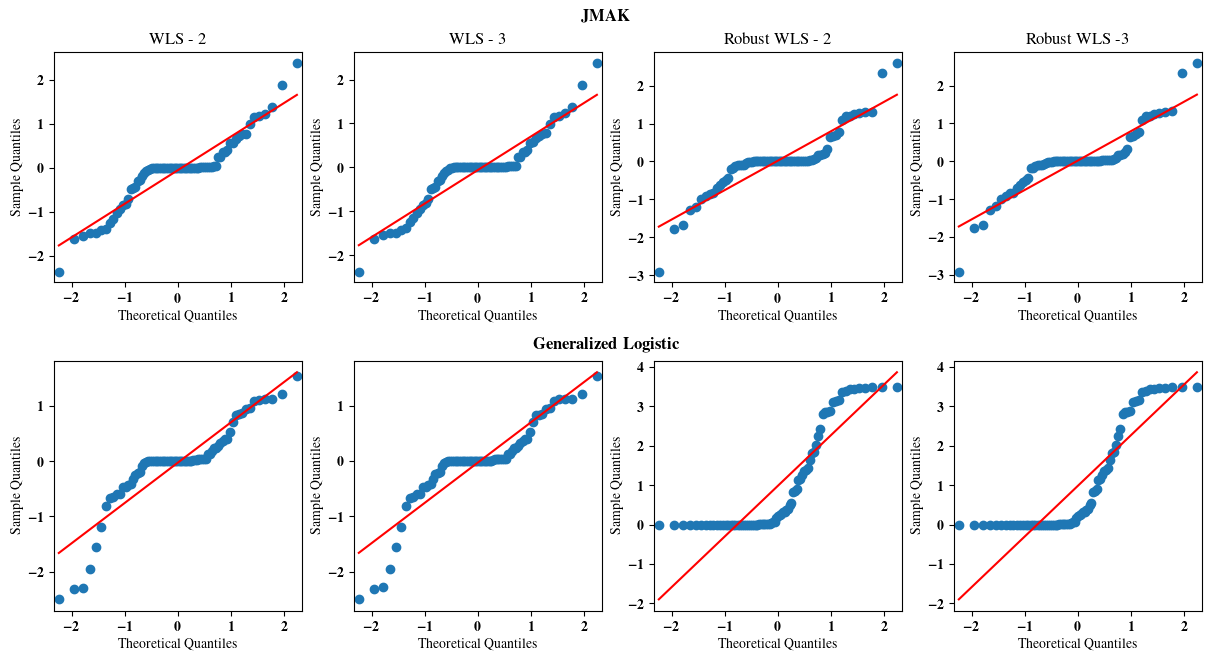

In [291]:
from statsmodels.graphics.gofplots import qqplot


file = 'highly_rolled.csv'

fig = plt.figure(constrained_layout=True,figsize= (12,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)
axes = []
for row, subfig,row_title in zip(range(2),subfigs,['JMAK','Generalized Logistic']):
    subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)

    axs = subfig.subplots(nrows=1, ncols=4)
    axes.append(axs)


axes = np.array(axes)

for j,label in enumerate(labels):
    axes[0,j].set_title(label,fontsize = 12)

t,T,X,df= read_prepare_data(f'rf_data/alfonso_data/{file}',mult = 3600.,exclude_index = data_files[file])
for i,model_name in enumerate(models[file]):

    for j,key in enumerate(models[file][model_name]):

        model = models[file][model_name][key]

        xx = np.array([t,T]).T
        resid = X - model(xx)
        S = np.std(resid,ddof = 5)
        s = df['std'].to_numpy()
        std_resid = 2**0.5*resid/(s + S)
        potential_outliers = np.arange(len(s))[np.abs(std_resid) > 3]
        print('potential outliers:',potential_outliers)

        qqplot(std_resid,line = 's',ax = axes[i,j])




### Extrapolation

result for file: highly_rolled.csv
                  model             method      n      a1         B1      a2  \
0                  JMAK         weighted_2  1.572  16.996 -39878.134 -16.528   
0                  JMAK  weighted_robust_2  2.005   5.965 -23527.407 -20.181   
0  Generalized Logistic         weighted_2  0.019  15.862 -37065.893 -43.105   
0  Generalized Logistic  weighted_robust_2  0.620   3.981 -18741.848 -14.851   

          B2      mse  max abs. error  
0  39588.611  214.337         772.200  
0  44919.398   30.568         103.267  
0  74933.557   40.825         147.051  
0  37673.432  320.267        1153.589  
----------------------------------------

result for file: moderate_roll.csv
                  model             method      n      a1         B1      a2  \
0                  JMAK         weighted_2  1.181  35.920 -72379.462 -32.565   
0                  JMAK  weighted_robust_2  1.010  34.422 -69886.000 -33.218   
0  Generalized Logistic         weighted_2  0.0

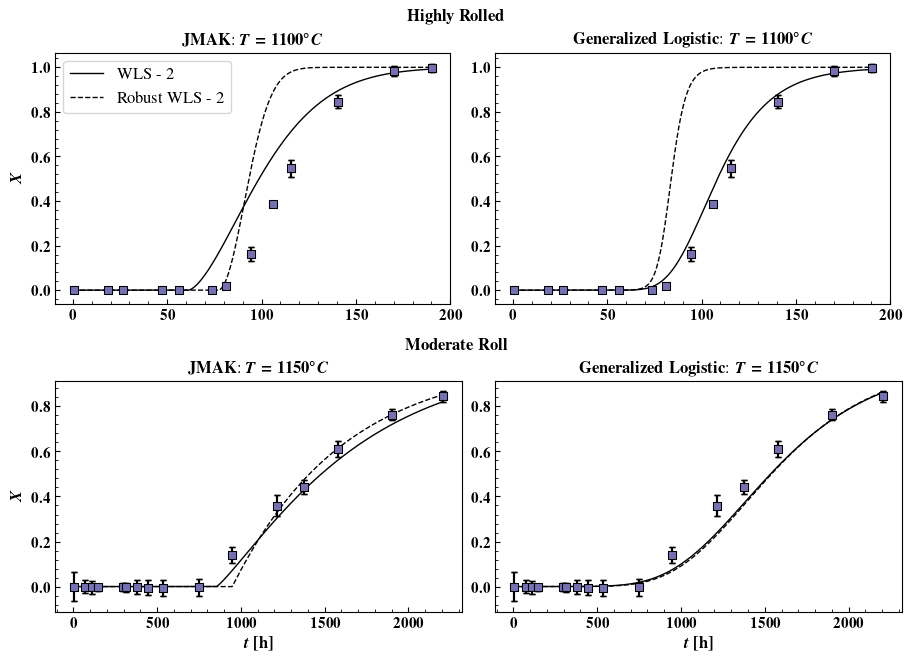

In [313]:
import copy

model_fit = {'JMAK':(jmak_fit_model_setup,jmak_function),
        'Generalized Logistic':(gl_fit_model_setup,generalized_logistic)}

methods = {'weighted_2':(2,'linear'),
           'weighted_robust_2':(2,'huber')}

models = {}
styles = ['-','--']
labels = ['WLS - 2','Robust WLS - 2']
fig = plt.figure(constrained_layout=True,figsize= (9,6.5))
subfigs = fig.subfigures(nrows=2, ncols=1)

axes = []
for row, subfig,row_title in zip(range(2),subfigs,['Highly Rolled','Moderate Roll']):
        subfig.suptitle(r'\textbf{' + row_title +  '}',fontsize = 12)
        axs = subfig.subplots(nrows=1, ncols=2)
        axes.append(axs)

axes = np.array(axes)

colors = plt.get_cmap('Dark2')([0.2,0.3])

data_files = {'highly_rolled.csv': [22,36],
                'moderate_roll.csv':[33,44,45]}

for j,file,Tmin in zip(range(2),data_files,[1100,1150]):
        results_frames = []
        models[file] = {}
        data_file = f'rf_data/alfonso_data/{file}'
        data = pd.read_csv(data_file,index_col = 0)

        for i,model_to_fit in enumerate(model_fit):
                setup,fit_func = model_fit[model_to_fit]
                models[file][model_to_fit] = {} 
                
                for method,ls,label in zip(methods,styles,labels): 
                        results = [] 
                        model_order,loss = methods[method]
                        if model_to_fit == 'JMAK':
                                t,T,X,df,bounds = setup(data_file,mult = 3600.,
                                                        exclude_index = data_files[file],
                                                        **{'tinc_order':model_order,'b_order':model_order})

                        else:
                                t,T,X,df,bounds = setup(data_file,mult = 3600.,
                                                        exclude_index = data_files[file],
                                                        **{'M_order':model_order,'B_order':model_order})
                        
                        train_idx = T > Tmin + 273.15
                        test_idx = T <= Tmin + 273.15
                        
                        sigma = df['std'].to_numpy()

                        model = ModelFunc().fit(fit_func,t[train_idx],T[train_idx],X[train_idx],
                                                local_optimize_ls,bounds.copy(),ap1_order = model_order,
                                                ap2_order = model_order,sigma = sigma[train_idx],loss = loss,max_nfev = int(5e3))
                        models[file][model_to_fit][method] = copy.deepcopy(model)
                        
                        resid = X[test_idx] - model(np.array([t[test_idx],T[test_idx]]).T)
                        mse = np.mean((resid/sigma[test_idx])**2)**0.5
                        max_err = np.max(np.abs(resid/sigma[test_idx]))
                        results.append([model_to_fit,method,
                                        *np.round(model.parameters(),3),
                                        round(mse,3),
                                        round(max_err,3)])

                        columns = ['model','method','n','a1','B1','a2','B2','mse','max abs. error']
                        
                        results_frames.append(pd.DataFrame(results,columns = columns))  
                
                        title = r'\textbf{' + f'{model_to_fit}' + '}' + f': $T = {Tmin} ^\circ C$'
                        

                
                        data_df = data.loc[data['temperature'] == Tmin]
                        tplot = np.linspace(0,data_df['time'].max()*3600,1000)
                        Xnew = np.array([tplot,(Tmin + 273.15)*np.ones_like(tplot)]).T
                        axes[j,i].plot(tplot/3600,model(Xnew),
                                color = 'k',lw = 1.,label = label,ls = ls)
                        

                        axes[j,i].set_title(title,fontsize = 12)
                        axes[j,i].errorbar(data_df['time'],data_df['X'].to_numpy(),yerr = data_df['std'],fmt = 'none',ecolor = 'k',capsize = 2)
                        axes[j,i].scatter(data_df['time'],data_df['X'],facecolor  = color,edgecolor = 'k',
                                lw = 0.75,s = 30,marker = marker,zorder = 1000) 
                

        print(f'result for file: {file}')
        print(pd.concat(results_frames))

        print('----------------------------------------\n')


for ax in np.ravel(axes)[2:]:
        ax.set_xlabel(r'$t$ \textbf{[h]}',fontsize = 12)

for ax in np.ravel(axes):
        setup_axis_default(ax)

for i in range(2):
        axes[i,0].set_ylabel(r'$X$',fontsize = 12)

#fig.subplots_adjust(hspace = 0.3,top = 0.1,right = 0.1,left = 0.1,bottom = 0.1,wspace = 0.25)

axes[0,0].legend(fontsize = 12)
#fig.savefig('images/example_model_fits.svg',bbox_inches = 'tight')
print('----------------------------------------\n\n')